# Import Libraries

In [ ]:
import os, shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


# Data Preparation

## Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m053annisadwi","key":"d7b3f15ca8407c152ca7f68fedea4cbc"}'}

In [ ]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 64% 103M/161M [00:00<00:00, 1.08GB/s]
100% 161M/161M [00:00<00:00, 970MB/s] 


In [ ]:
!unzip corn-or-maize-leaf-disease-dataset.zip

Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Corn_Blight (1010).JPG  
  inflating: data/Blight/Corn_Blight (1011).jpg  
  inflating: data/Blight/Corn_Blight (1012).JPG  
  inflating: data/Blight/Corn_Blight (1013).JPG  
  inflatin

In [ ]:
# Menentukan direktori untuk dataset
dataset_dir = "/content/data"

## Plot Gambar untuk Semua Kelas

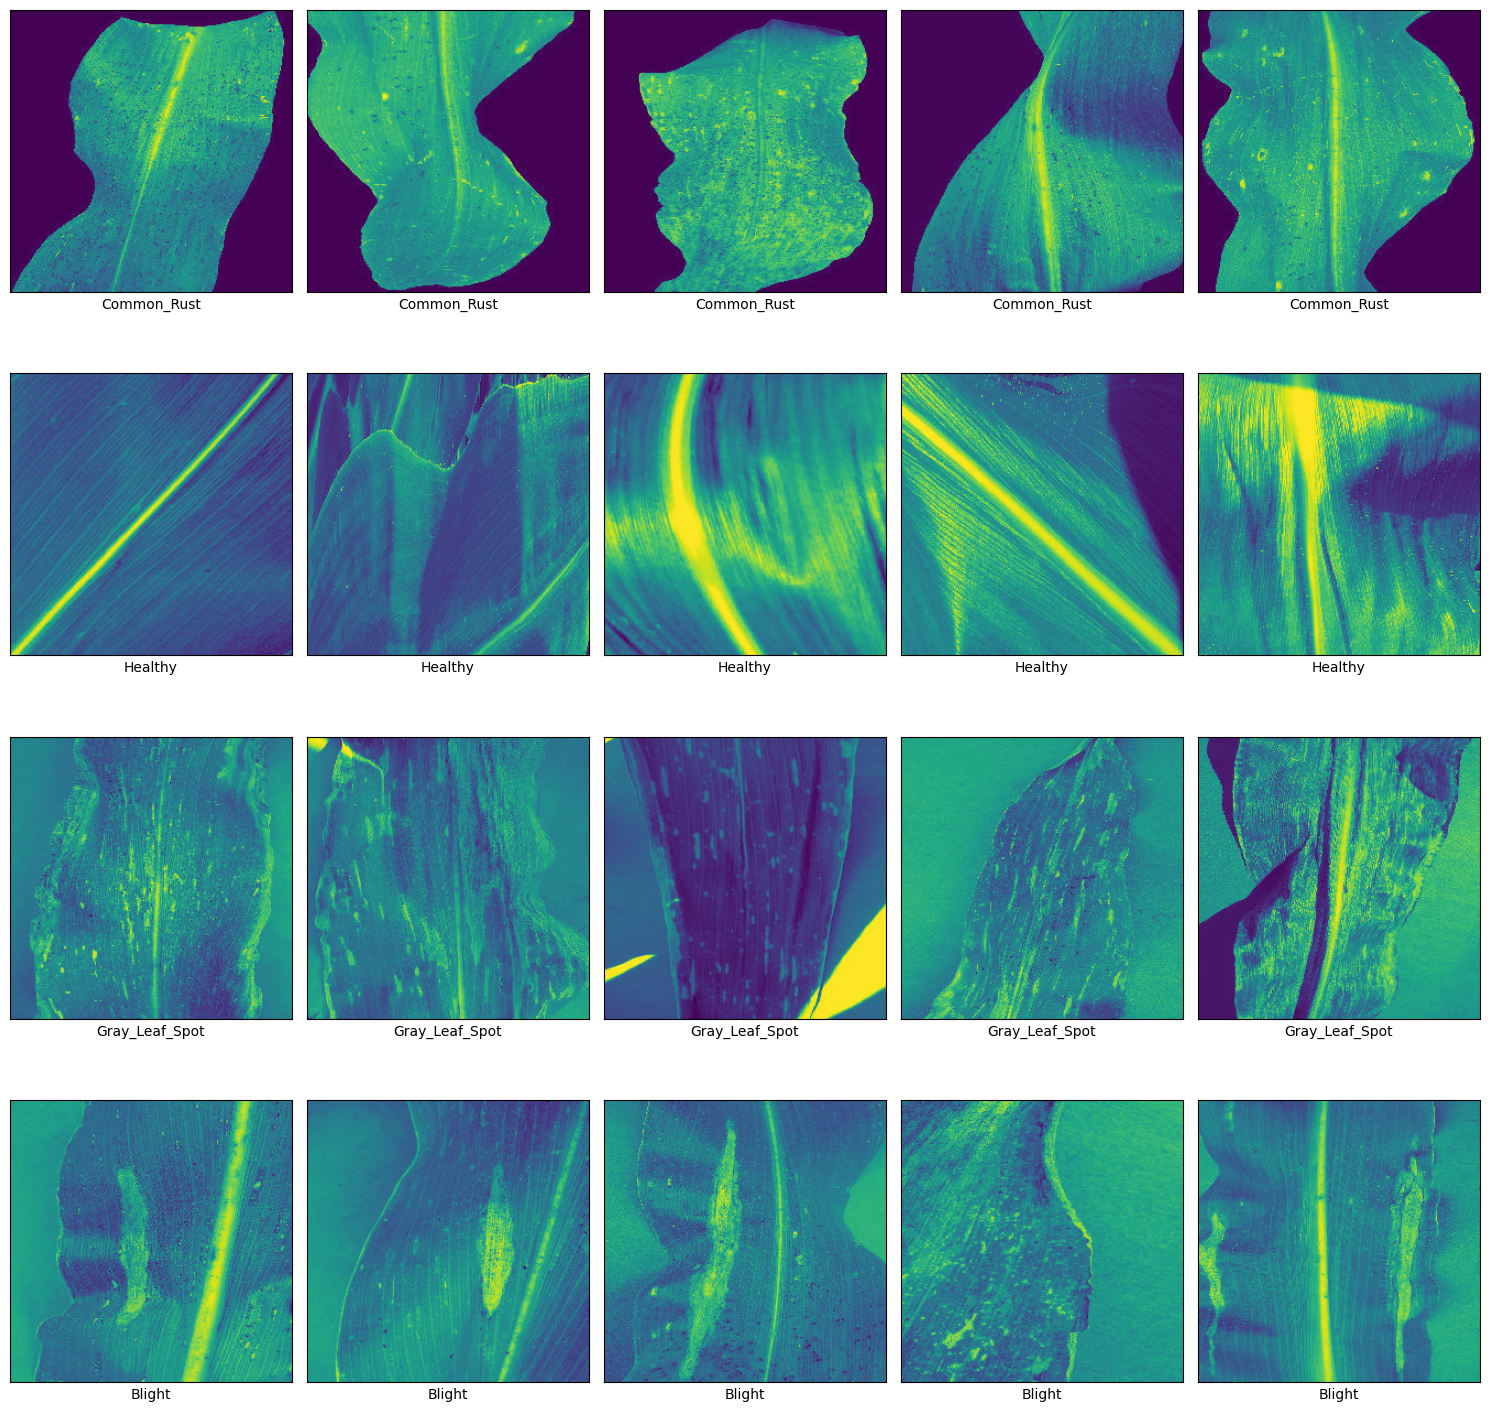

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
cornleaf_image = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        cornleaf_image[class_name] = os.listdir(class_path)

fig, axs = plt.subplots(len(cornleaf_image.keys()), 5, figsize=(15, 15))
for i, class_name in enumerate(cornleaf_image.keys()):
    if len(cornleaf_image[class_name]) >= 5 :
        images = np.random.choice(cornleaf_image[class_name], 5, replace=False)
        for j, image_name in enumerate(images):
            img_path = os.path.join(dataset_dir, class_name, image_name)
            try:
                img = Image.open(img_path).convert("L")
                axs[i, j].imshow(img)
                axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    else:
        print(f"Class {class_name} has less than 5 images.")

fig.tight_layout()
plt.show()


## Plot Distribusi Tiap Kelas

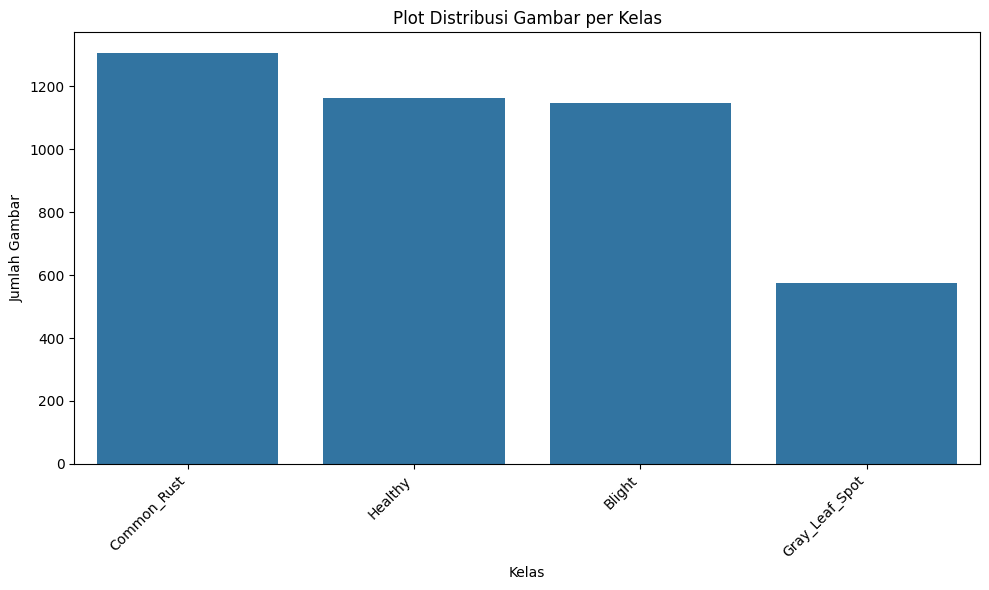

In [ ]:
class_counts = {class_name: len(images) for class_name, images in cornleaf_image.items()}

sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_class_counts.keys()), y=list(sorted_class_counts.values()))
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.title("Plot Distribusi Gambar per Kelas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Data Prepocessing

## Split Dataset

In [ ]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)

        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

        for image_name in train_images:
            shutil.copy(os.path.join(class_path, image_name), os.path.join(train_dir, class_name, image_name))

        for image_name in val_images:
            shutil.copy(os.path.join(class_path, image_name), os.path.join(val_dir, class_name, image_name))

        for image_name in test_images:
            shutil.copy(os.path.join(class_path, image_name), os.path.join(test_dir, class_name, image_name))

train_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)}
val_counts = {class_name: len(os.listdir(os.path.join(val_dir, class_name))) for class_name in os.listdir(val_dir)}
test_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in os.listdir(test_dir)}

print(f"Train counts: {train_counts}")
print(f"Validation counts: {val_counts}")
print(f"Test counts: {test_counts}")


Train counts: {'Common_Rust': 1044, 'Healthy': 929, 'Gray_Leaf_Spot': 459, 'Blight': 916}
Validation counts: {'Common_Rust': 131, 'Healthy': 116, 'Gray_Leaf_Spot': 57, 'Blight': 115}
Test counts: {'Common_Rust': 131, 'Healthy': 117, 'Gray_Leaf_Spot': 58, 'Blight': 115}


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
train_data = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=1337
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'dataset/val',
    target_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=1337
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=1337
)

Found 3348 images belonging to 4 classes.
Found 419 images belonging to 4 classes.
Found 421 images belonging to 4 classes.


In [ ]:
test_generator.class_indices

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

# Modelling

In [ ]:
n_classes = 4
CHANNELS = 3

# Define the model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),

    # First Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

     # Second Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Dense Layers
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,756 (979.52 KB)

 Trainable params: 250,052 (976.77 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Compiling the Model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)
# Add ModelCheckpoint to callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

y_train = train_generator.classes  # ambil label dari sini
# Add ClassWeights untuk mengatasi data imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping,reduce_lr,model_checkpoint],
    batch_size=BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 621ms/step - accuracy: 0.7312 - loss: 0.7007 - val_accuracy: 0.5274 - val_loss: 1.9970 - learning_rate: 0.0010
Epoch 2/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 515ms/step - accuracy: 0.8544 - loss: 0.4016 - val_accuracy: 0.4869 - val_loss: 1.9997 - learning_rate: 0.0010
Epoch 3/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 521ms/step - accuracy: 0.8635 - loss: 0.3464 - val_accuracy: 0.2816 - val_loss: 4.6288 - learning_rate: 0.0010
Epoch 4/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8691 - loss: 0.3323
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 513ms/step - accuracy: 0.8692 - loss: 0.3323 - val_accuracy: 0.3365 - val_loss: 2.1858 - learning_rate: 0.0010
Epoch 5/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.8921 - loss: 0.2857 - val_accuracy: 0.7900 - val_loss: 0.4655 - learning_rate: 1.0000e-04
Epoch 6/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 515ms/step - accuracy: 

## Evaluasi dan Visualisasi

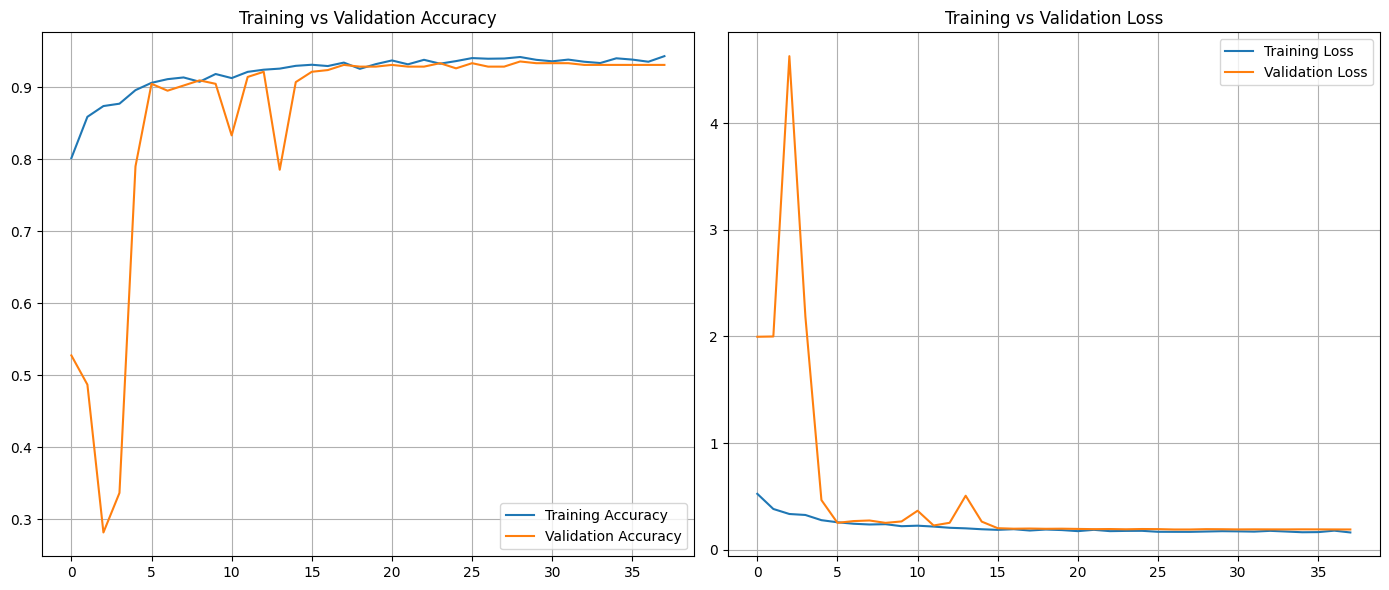

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
Classification Report:

                precision    recall  f1-score   support

        Blight       0.90      0.87      0.88       115
   Common_Rust       0.99      0.95      0.97       131
Gray_Leaf_Spot       0.76      0.86      0.81        58
       Healthy       0.98      1.00      0.99       117

      accuracy                           0.93       421
     macro avg       0.91      0.92      0.91       421
  weighted avg       0.93      0.93      0.93       421



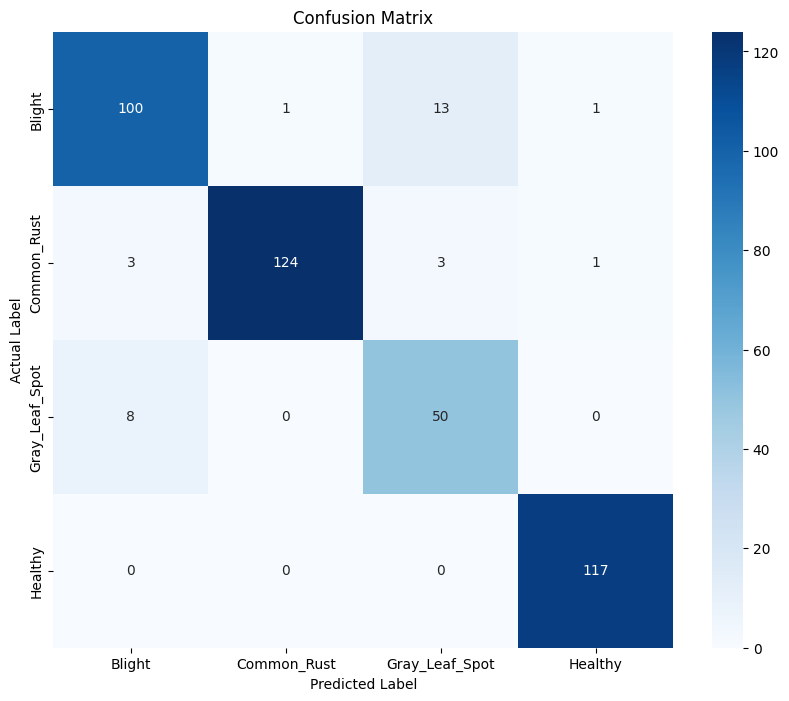

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
y_pred = model.predict(test_generator)
y_pred

array([[1.66525126e-01, 5.97446442e-01, 2.36027598e-01, 8.23785115e-07],
       [9.34231102e-01, 5.90867285e-06, 6.57621399e-02, 8.15140652e-07],
       [9.98650491e-01, 1.27263513e-06, 1.34562643e-03, 2.60460456e-06],
       [9.92139876e-01, 1.41691626e-05, 7.83793349e-03, 8.10563233e-06],
       [9.36750352e-01, 4.51068809e-05, 6.31915778e-02, 1.29865448e-05],
       [9.94557977e-01, 9.52720729e-05, 5.29651344e-03, 5.02707844e-05],
       [9.35227036e-01, 1.88816033e-04, 6.44662604e-02, 1.17914562e-04],
       [9.93185222e-01, 7.31493928e-05, 6.34686509e-03, 3.94708506e-04],
       [9.75425303e-01, 9.37433942e-05, 2.41230074e-02, 3.57838086e-04],
       [9.84308898e-01, 2.18822806e-05, 1.56153506e-02, 5.39411740e-05],
       [5.19799054e-01, 1.27298191e-01, 3.52488548e-01, 4.14205919e-04],
       [1.07137054e-01, 4.11321744e-02, 2.63117462e-01, 5.88613272e-01],
       [8.50780427e-01, 3.33321132e-02, 1.15880519e-01, 6.99286647e-06],
       [9.94811773e-01, 1.17403788e-05, 5.14401076e

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


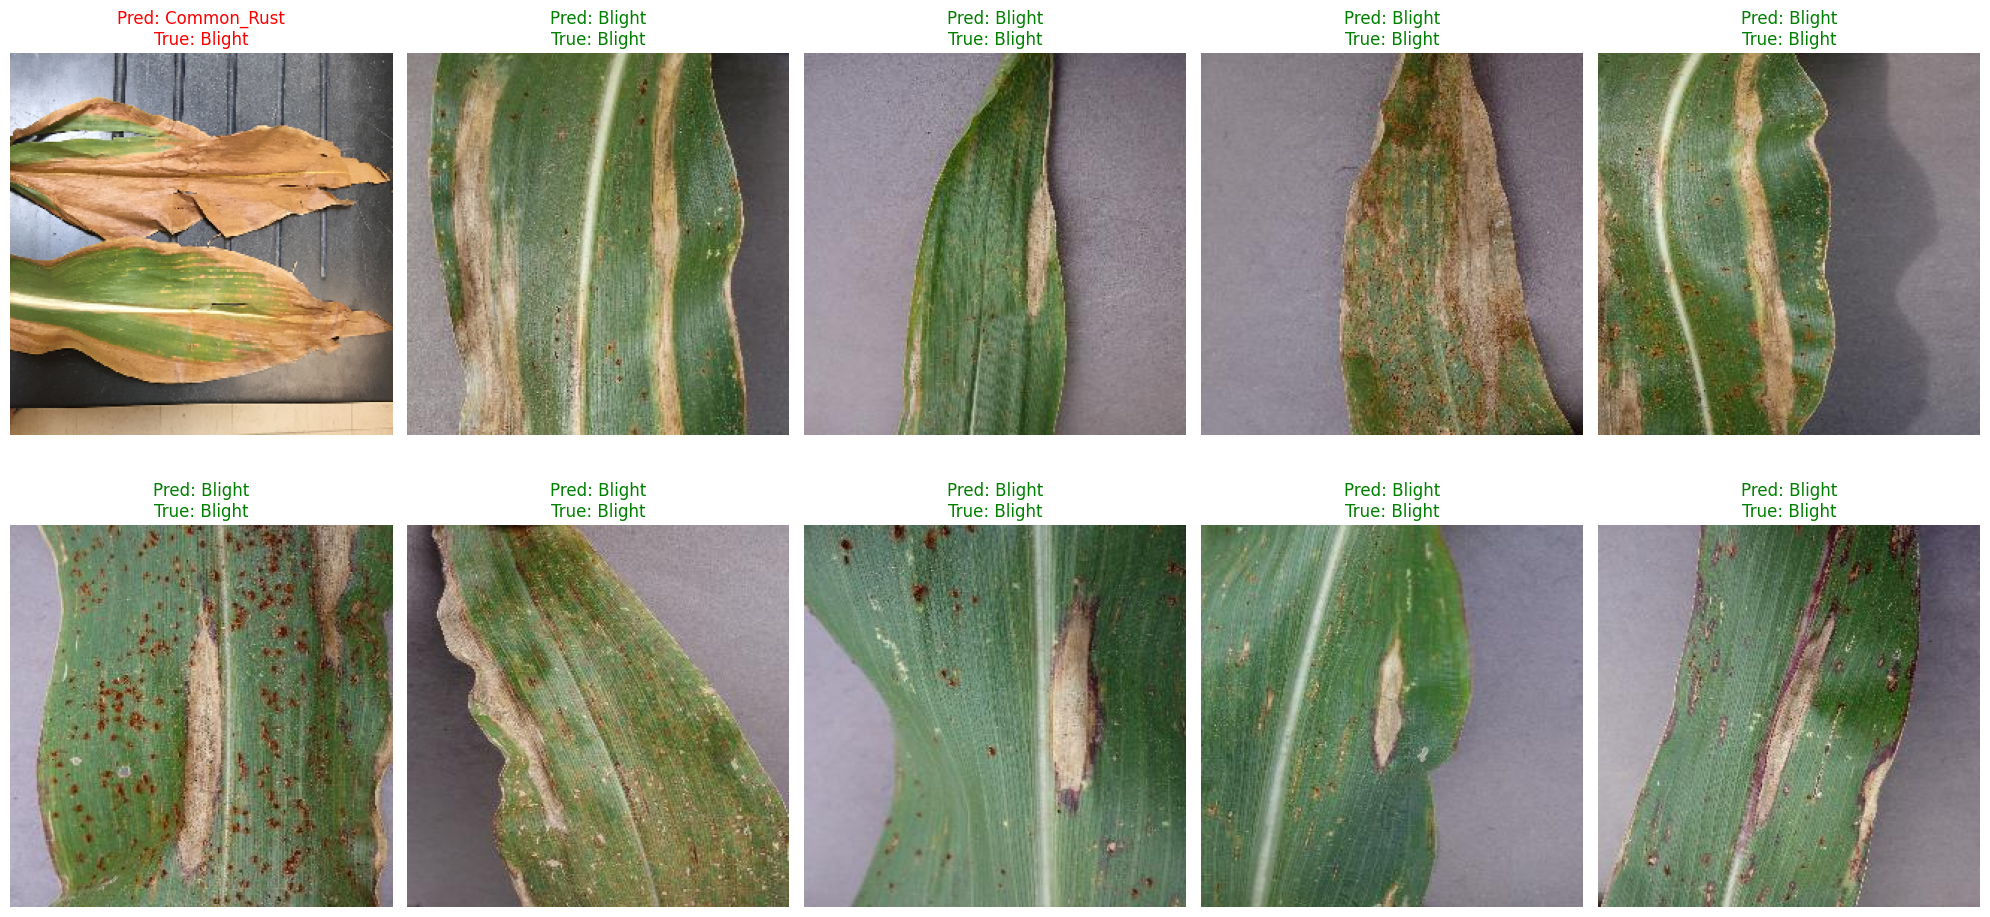

In [ ]:
test_generator.reset()

x_test, y_true = next(iter(test_generator))

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(20, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    true_label = label_map[int(y_true[i])]
    pred_label = label_map[y_pred_labels[i]]
    color = "green" if y_pred_labels[i] == int(y_true[i]) else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Convert Model

In [ ]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136732612455760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612456528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612459216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612456144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612455952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612458448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612458832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612458256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612460368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732524314704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136732612459792: Te

In [ ]:
import pickle

filename = 'final_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
os.makedirs("tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite")

Model berhasil dikonversi ke TFLite


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='StatefulPartitionedCall' \
    --saved_model_tags=serve \
    saved_model \
    tfjs_model

2025-06-02 13:36:53.628698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748871413.699379   30242 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748871413.710861   30242 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-02 13:37:00.255023: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748871420.255191   30242 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

# Inference

In [ ]:
def predict_image(img_path, model, class_indices, threshold=0.75):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_prob = np.max(prediction)
    predicted_class_index = np.argmax(prediction)

    label_map = {v: k for k, v in class_indices.items()}
    predicted_class_label = label_map[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    # cek threshold
    if predicted_prob >= threshold
      print(f"Terdeteksi: {predicted_class_index} dengan keyakinan {predicted_prob * 100:.2f}%")
      return predicted_class_index, predicted_prob
    else:
        print("Error: Objek tidak terdeteksi dengan keyakinan yang cukup.")
        return None, predicted_prob
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class_label}\nConfidence: {confidence:.2f}")
    plt.show()

    return predicted_class_label, confidence

In [ ]:
uploaded = files.upload()

Saving leaf2.jpg to leaf2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


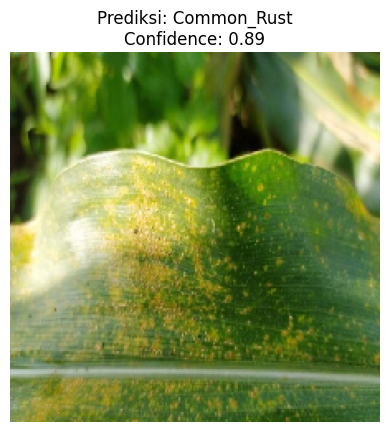

('Common_Rust', np.float32(0.8856022))

In [ ]:
predict_image("leaf2.jpg", model, test_generator.class_indices)